# HarvestStat Data Profiling - Mauritania

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:3243' # Mauritania
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/MR_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Mauritania',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1990	 | MR1990A1 | 13	| MR1990A2	| 45	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_1'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(',')[0])

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([MR_Admin1_1990, MR_Admin2_1990], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 3,988
Removed 1,107 "Missing Value" points
0/997 "Area Harvested" points are retained.
985/997 "Area Planted" points are retained.
953/997 "Quantity Produced" points are retained.
943/997 "Yield" points are retained.
Current data points: 2,881

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1989 - 2019
7 grain types are found: Cowpea (unspecified), Groundnuts (In Shell), Maize (Corn), Millet, Rice (Paddy), Sorghum, Wheat Grain
8 seasons are found: Annual (06-01), Main (09-01), Dam retention (02-01), Bas-fond (02-01), Hot off-season (06-01), Decrue controlee (04-01), Walo (04-01), Cold off-season (03-01)
6 crop production system are found: All (PS), dieri, dam irrigation, surface water, irrigated, parastatal recessional
Data sources include:
[1] Ministry of Rural Development, Mauritania --- FEWS NET Agro Maps, Mauritania
[2] Ministry of Rural Develop

- Mauritania crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-mauritania.png?itok=fcsQC56T" width=900><br>

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/wafrica_mr_calendar.png" width=900>

- comparison of boundaries

<img src="../figures/MR_admin_shapes.png" width=900>

- FDW data consists of `MR1990A1`.

- FEWS NET admin shapefiles ------------------- #

| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  | :---:  | :---:  |
| 1990	 | MR1990A1 | 13	| MR1990A2	| 45	| nan	| 0	|

- **`MR1990A1`** is used to represent the current admin-level 1 crop data.
- Mauritania has seven crop seasons: `Annual`, `Dam retention`, `Bas-fond`, `Main`, `Walo`, `Hot off-season`, `Cold off-season`.
- Mauritania has seven crop production systems: `none`, `dam irrigation`, `surface water`, `dieri`, `flood recessional` , `parastatal recessional` , `irrigated`.


In [4]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = MR_Admin1_1990.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# Link admin boundaries ------------------------- #
link, over = FDW_PD_CreateAdminLink(MR_Admin1_1990, MR_Admin1_1990, 'ADMIN1', 'ADMIN1', prod, epsg)
# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link, prod, over, mdx_pss)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=True)
# ----------------------------------------------- #

CBR is considered for 'MR1990A108' as no record found in: ['MR1990A108']
CBR is considered for 'MR1990A113' as no record found in: ['MR1990A113']
CBR is considered for 'MR1990A111' as no record found in: ['MR1990A111']


In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

All [country, season_name] are in the external season calendar.


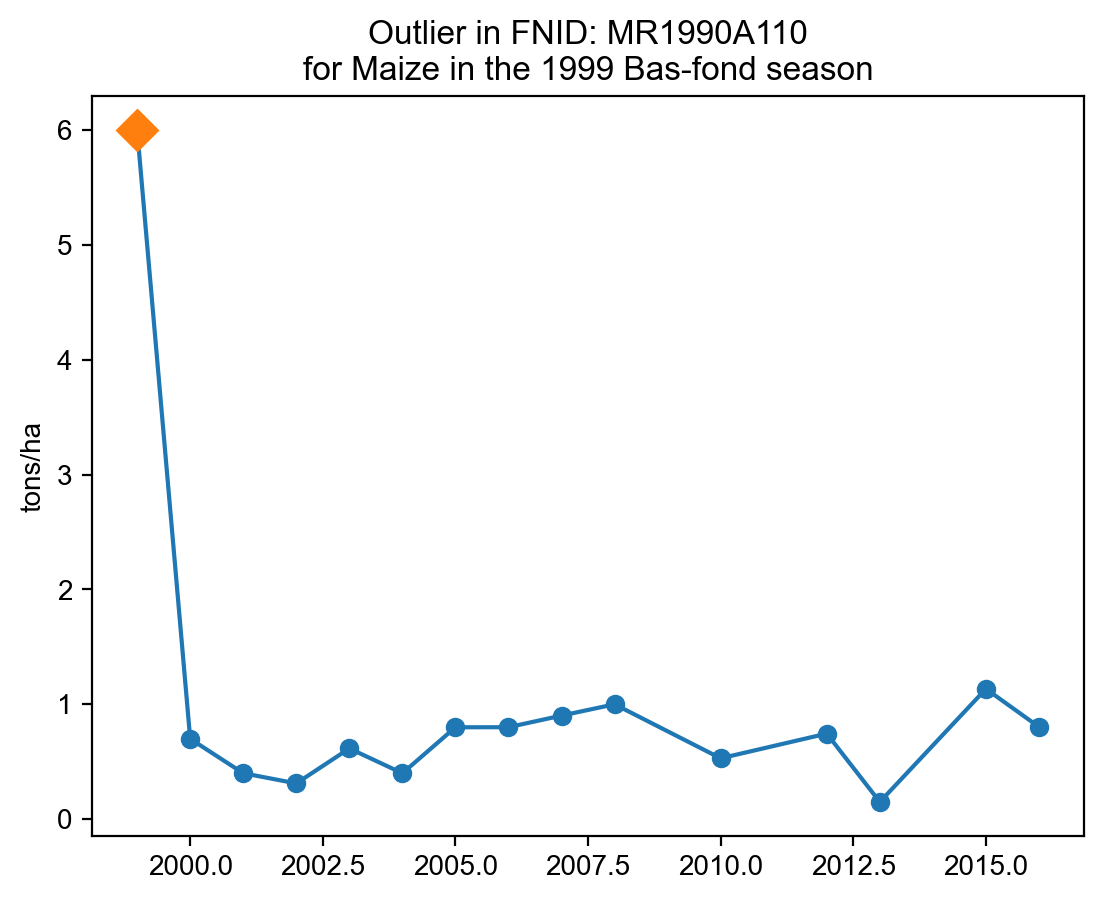

In [7]:
from matplotlib import pyplot as plt

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

outliers = [['MR1990A110','Maize','Bas-fond',1999],
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title('Outlier in FNID: '+iou[0]+'\nfor '+iou[1]+' in the '+str(iou[3])+' '+iou[2]+' season')
    plt.ylabel('tons/ha')
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1   
    

In [8]:
# Save data
fn_out = '../data/crop/adm_crop_production_MR.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_MR_ratio.npz', link_ratio)

../data/crop/adm_crop_production_MR.csv is saved.
../data/crop/adm_crop_production_MR_ratio.npz is saved.


## Visualization of production data

/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


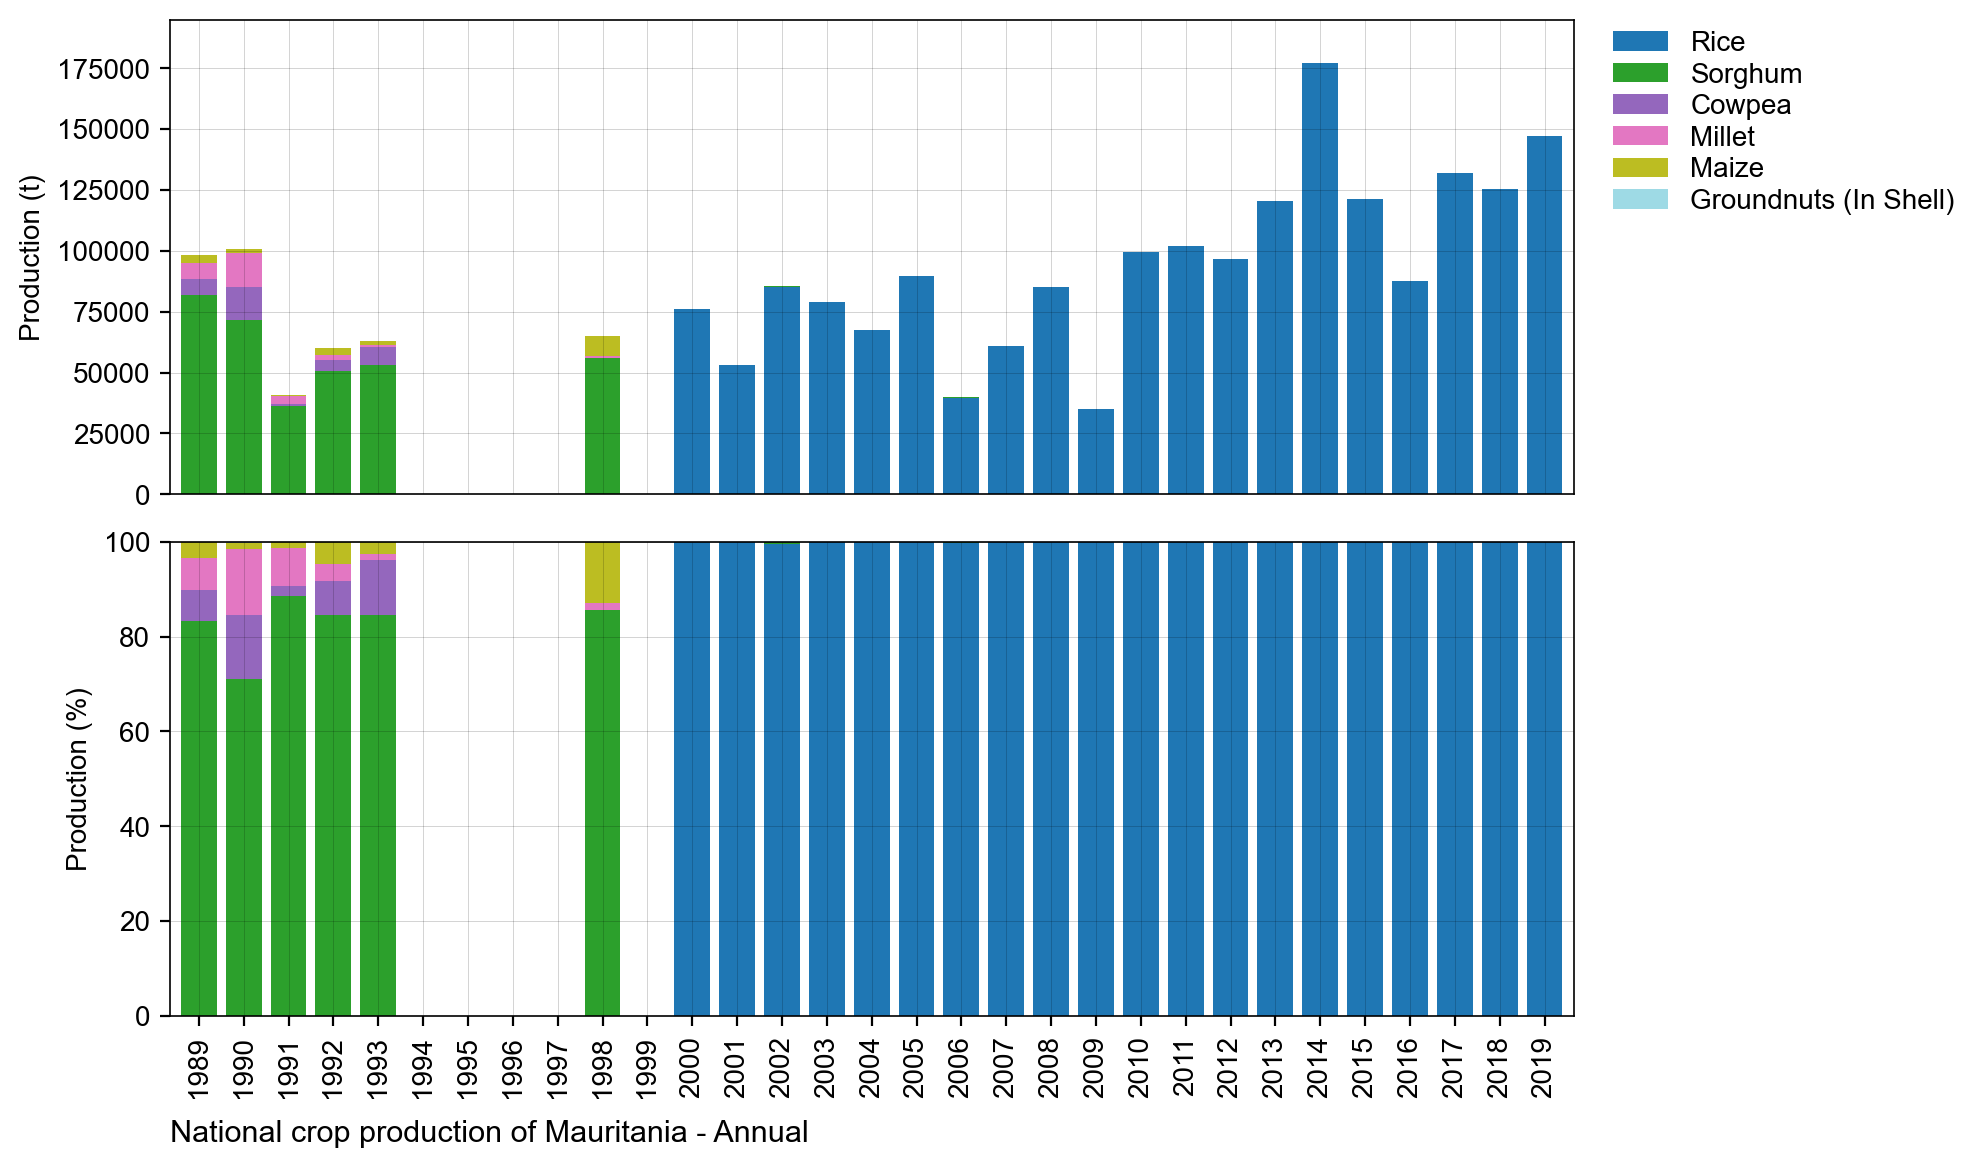

../figures/MR_bar_natgrainprod_Annual.png is saved.


/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


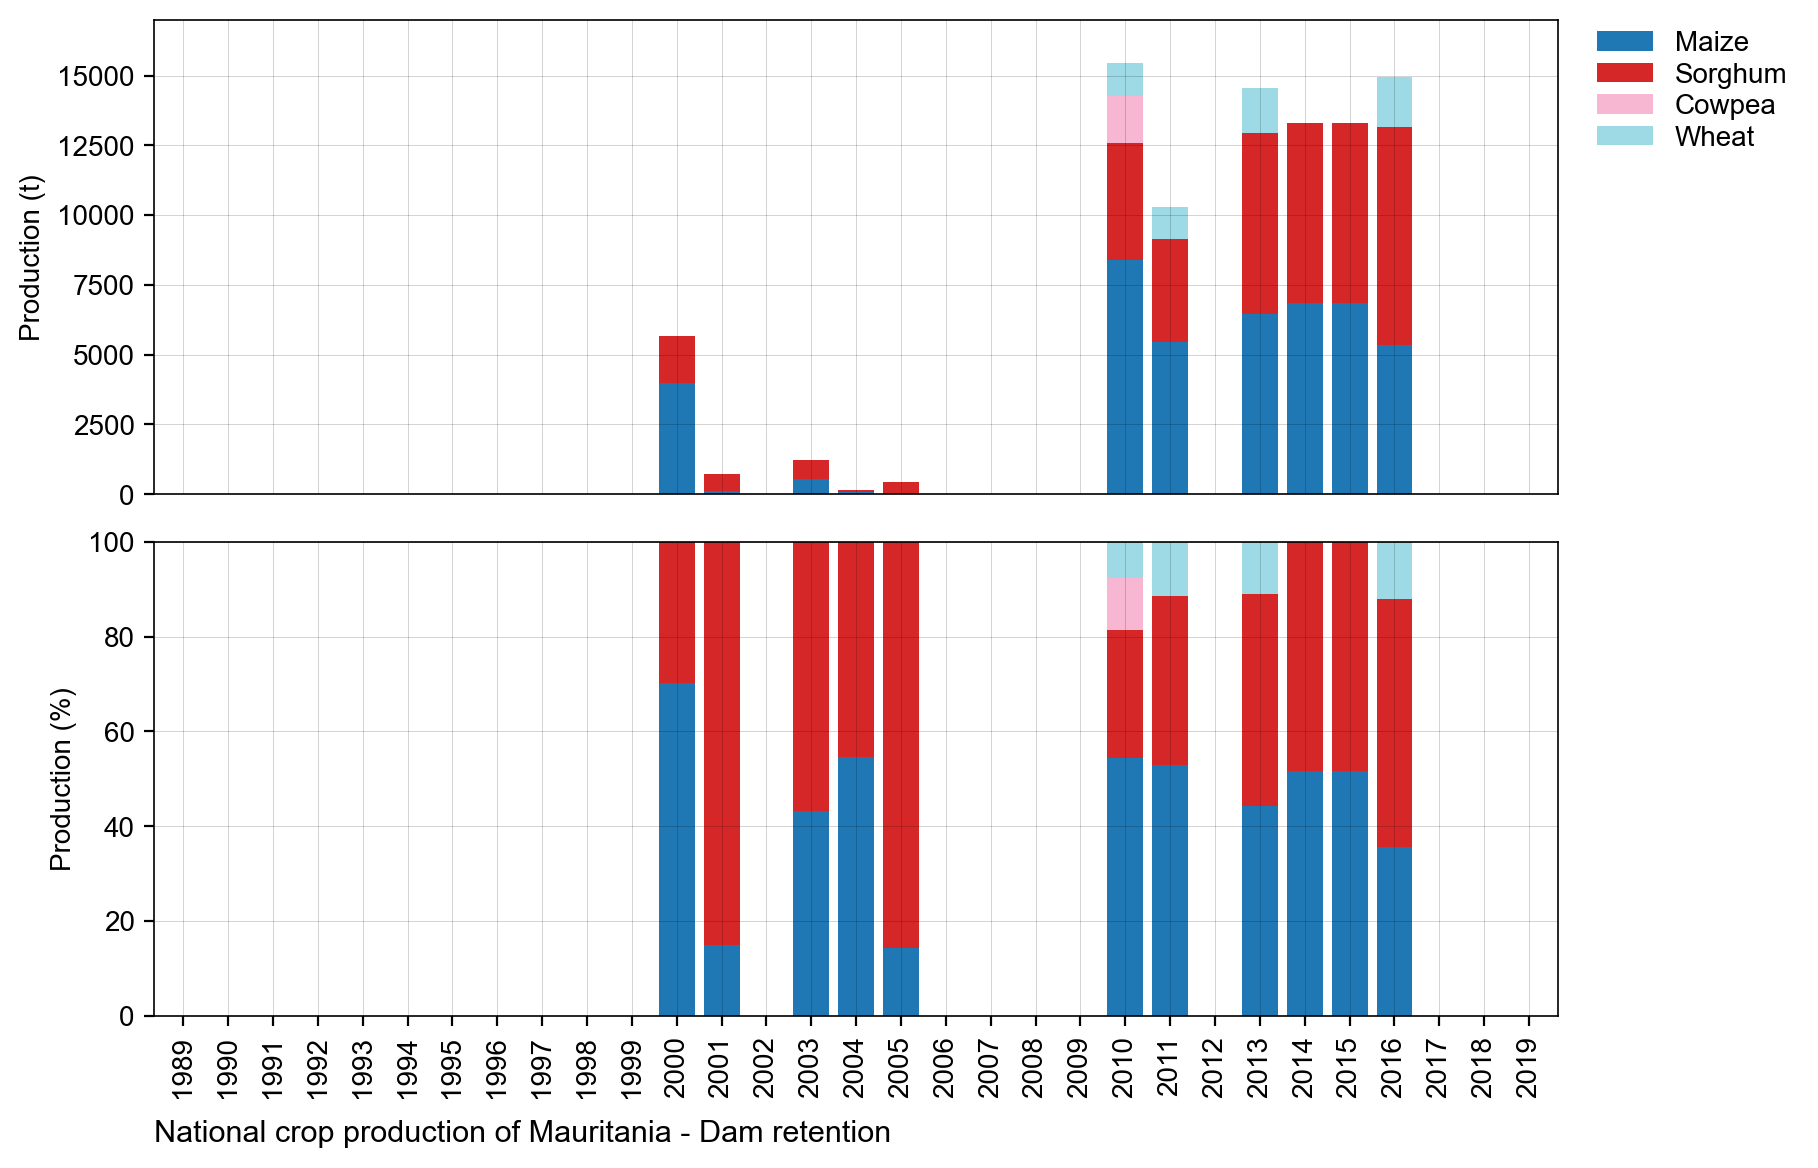

../figures/MR_bar_natgrainprod_Dam retention.png is saved.


/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


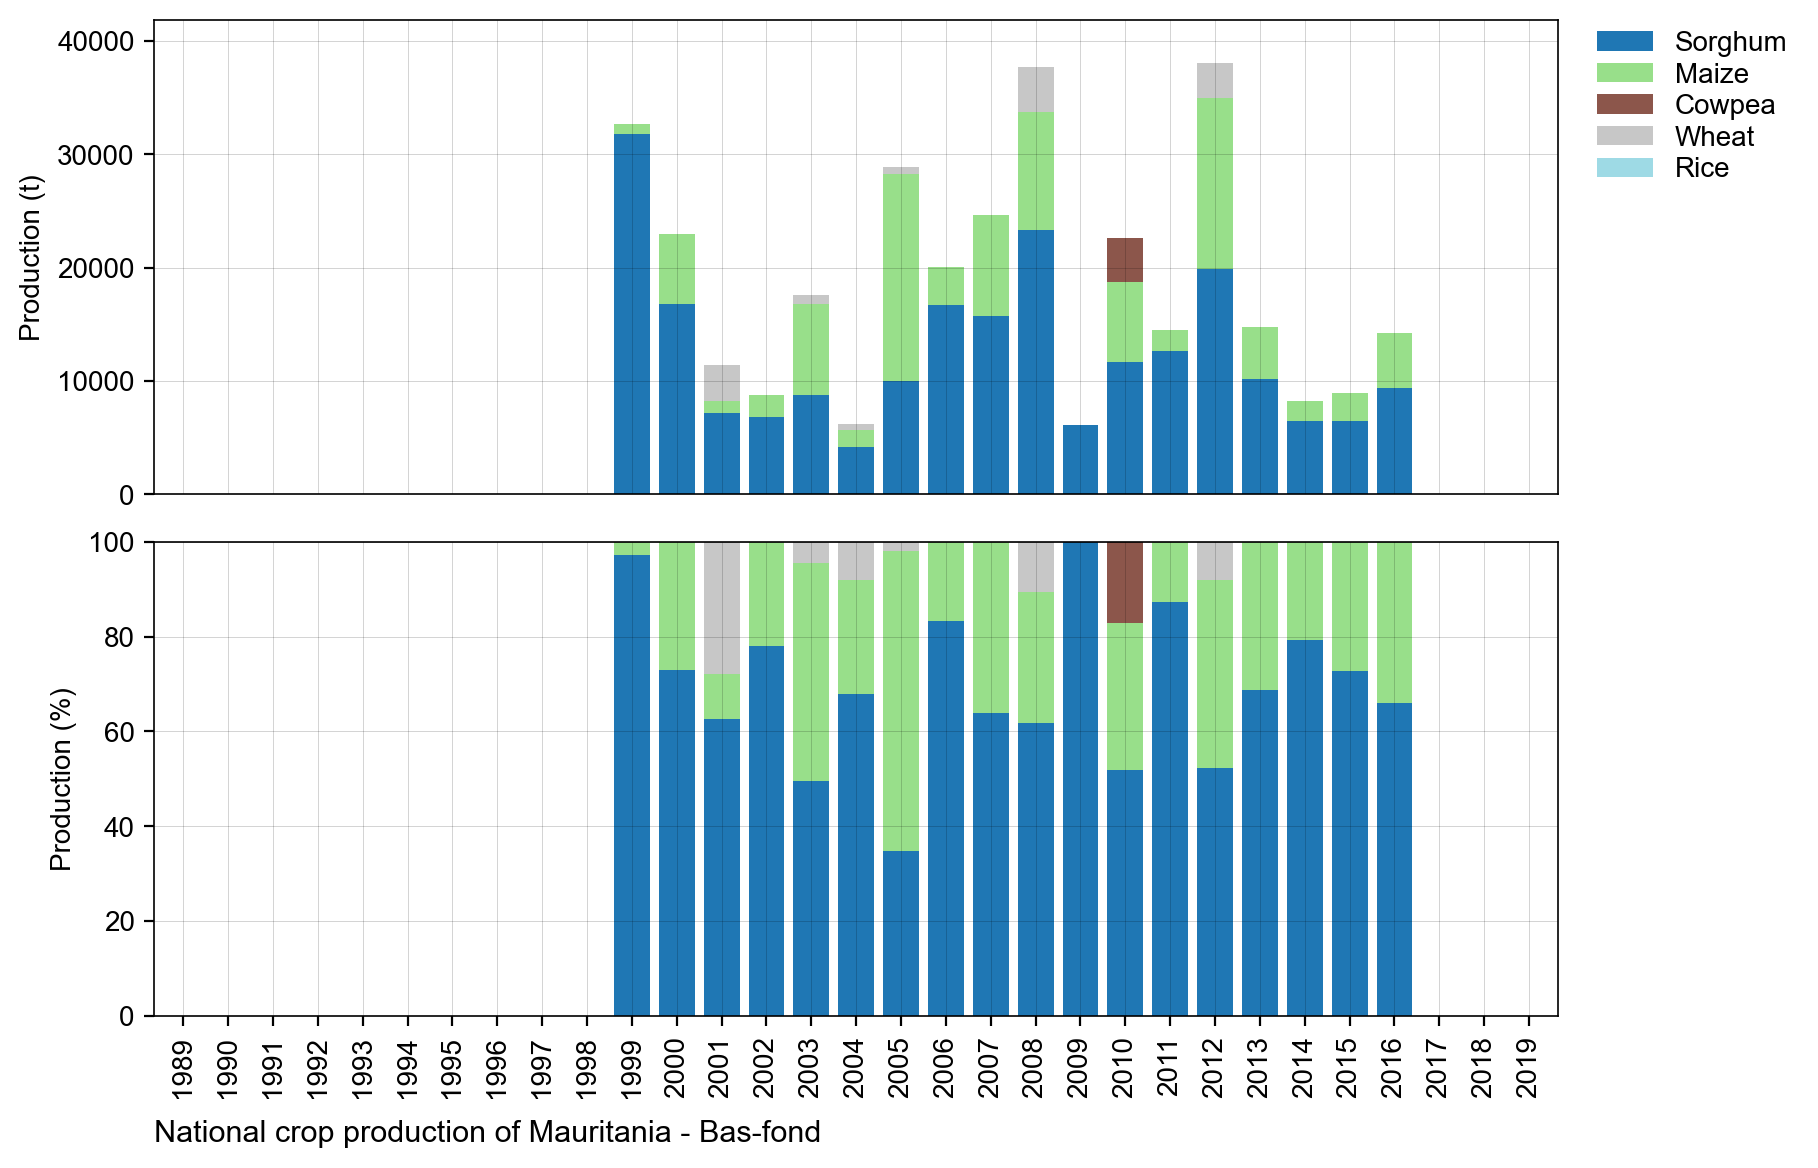

../figures/MR_bar_natgrainprod_Bas-fond.png is saved.


/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


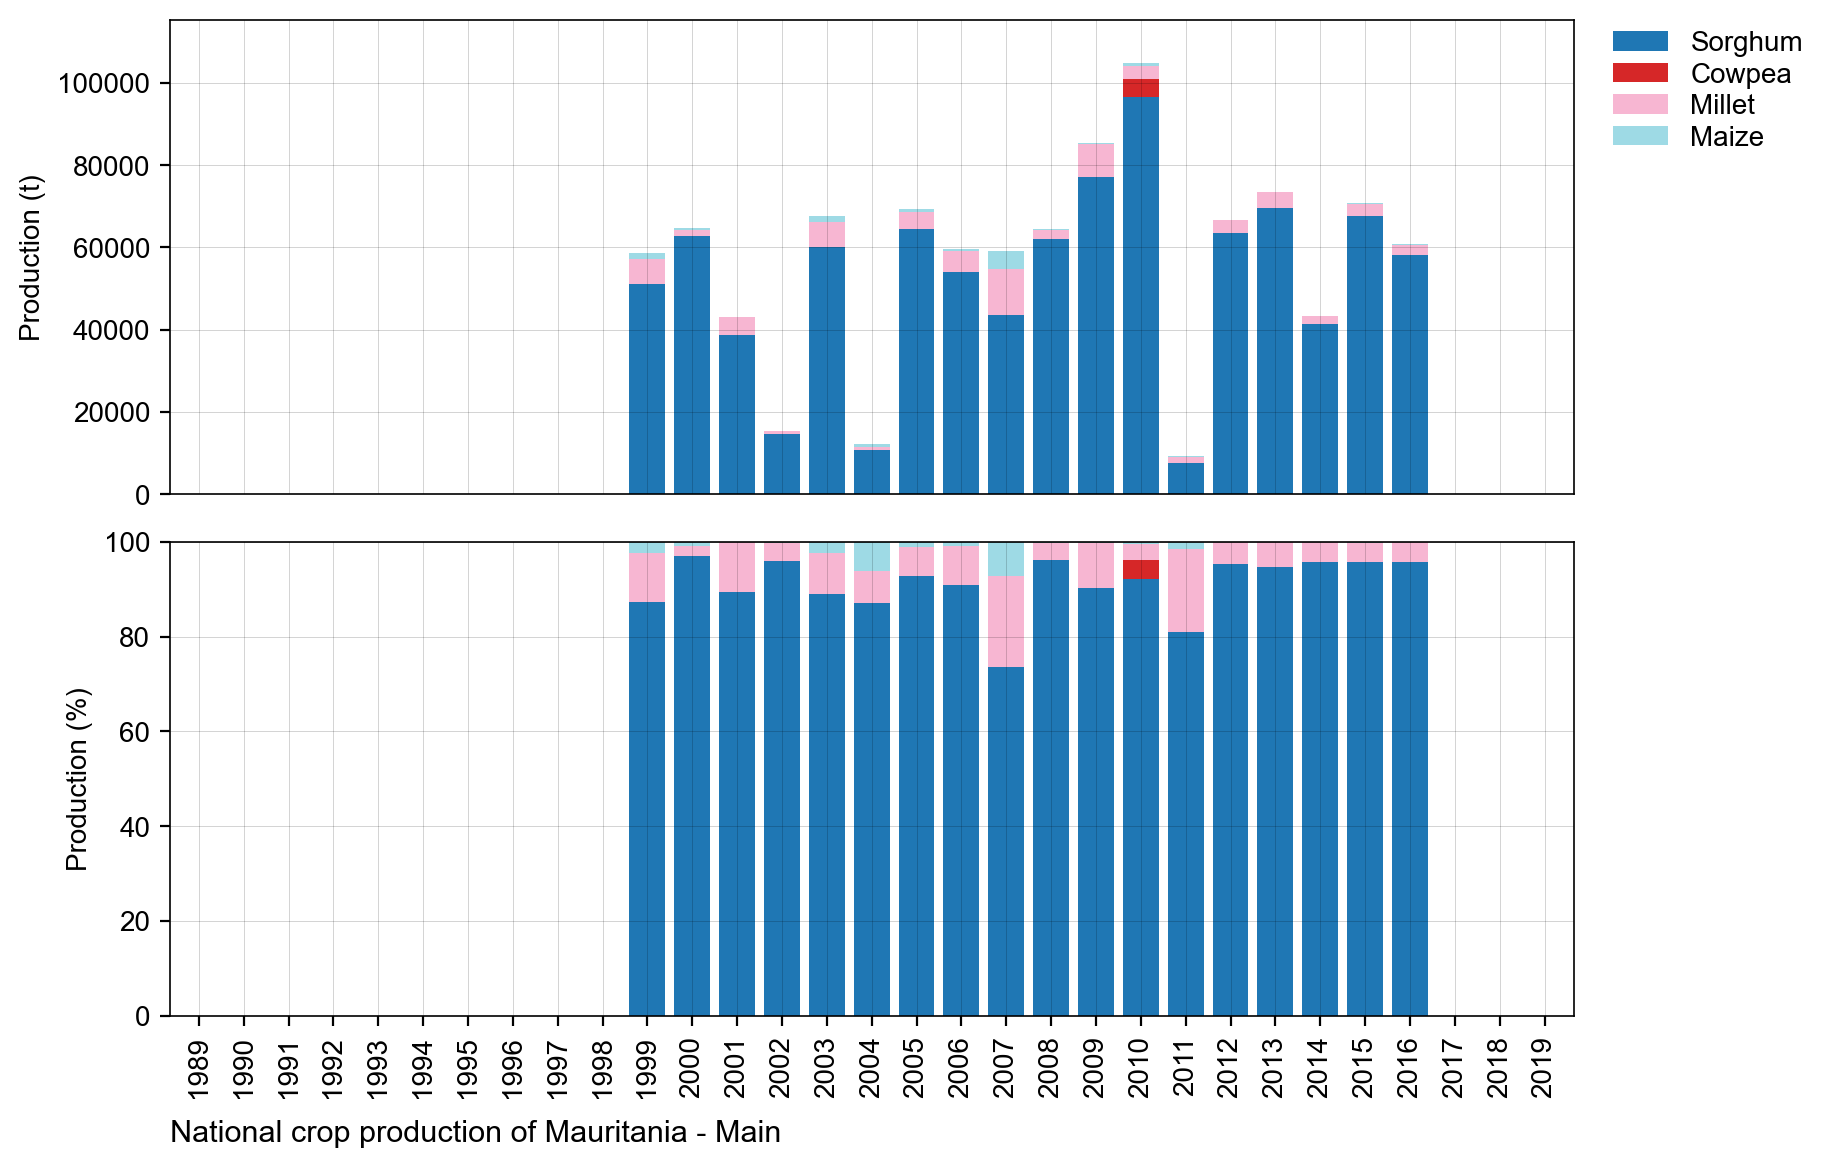

../figures/MR_bar_natgrainprod_Main.png is saved.


/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


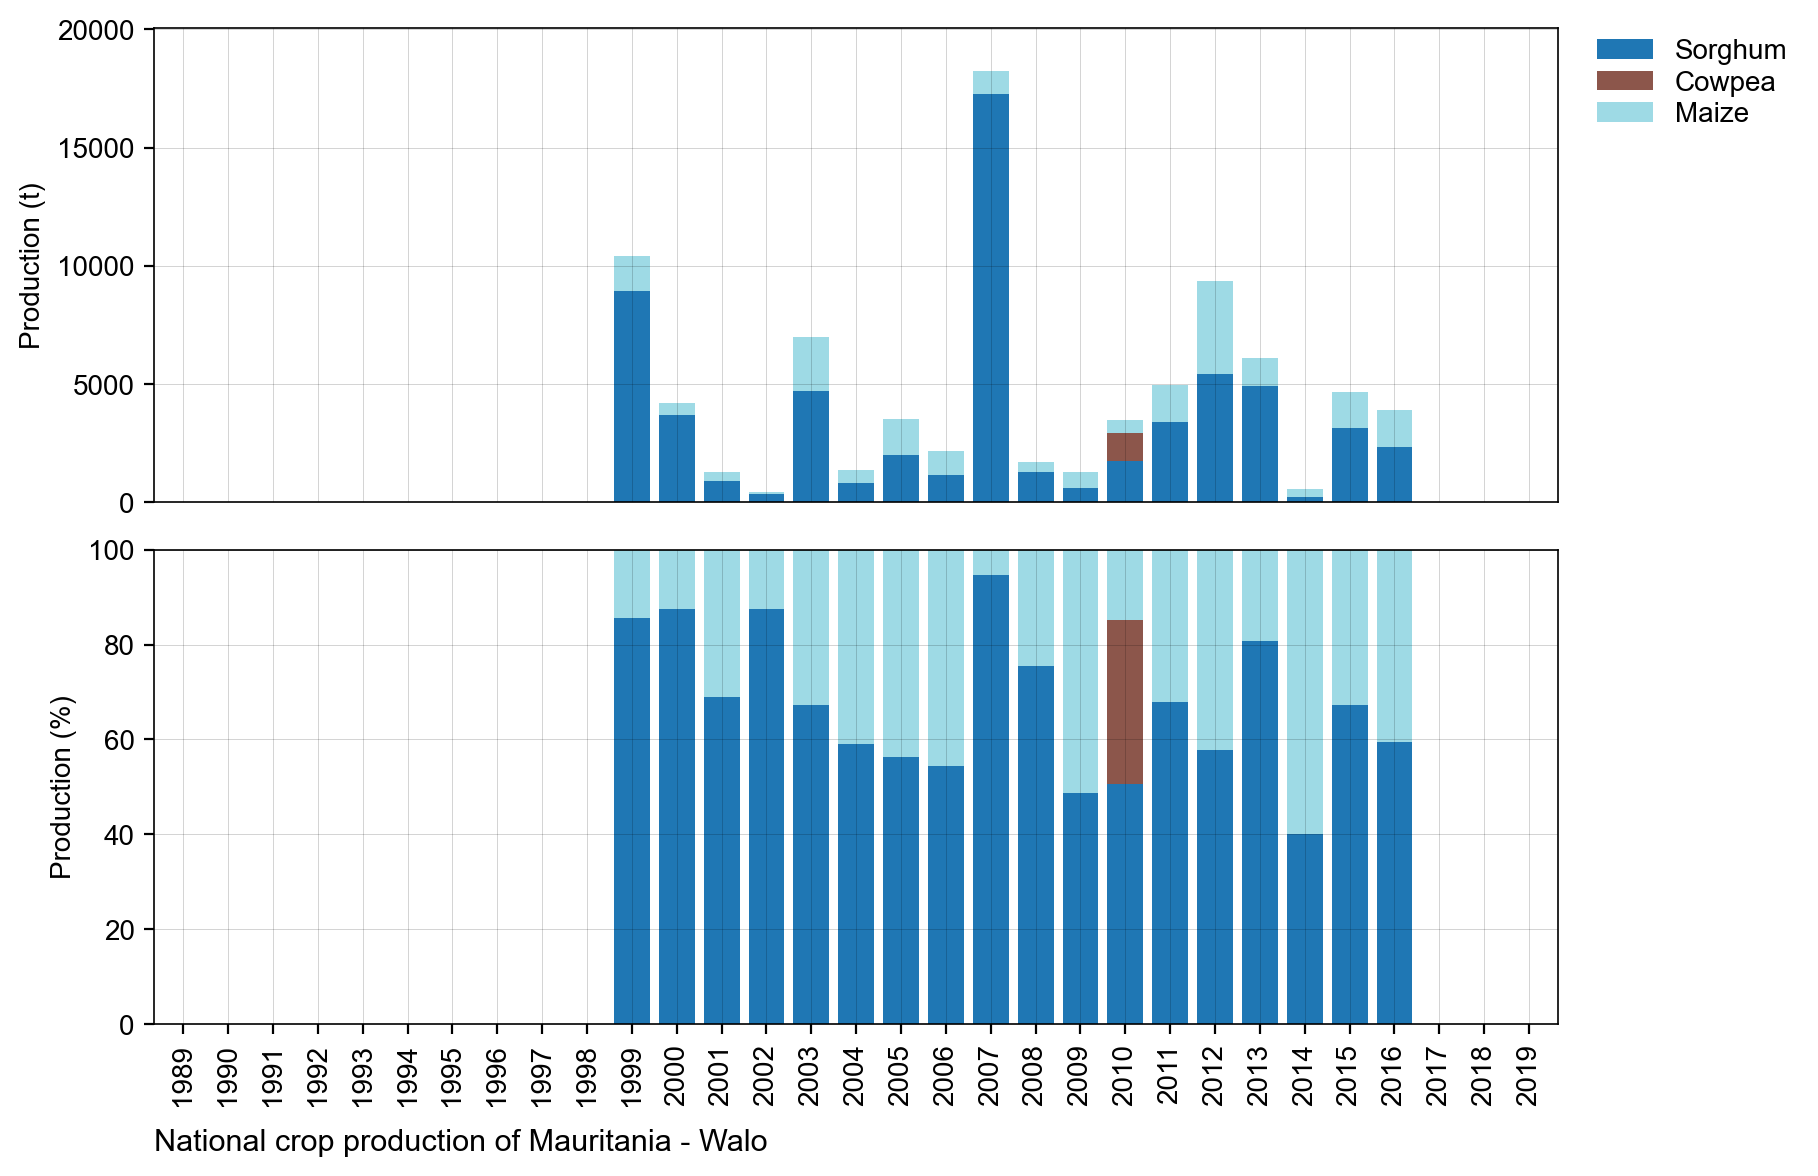

../figures/MR_bar_natgrainprod_Walo.png is saved.


/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


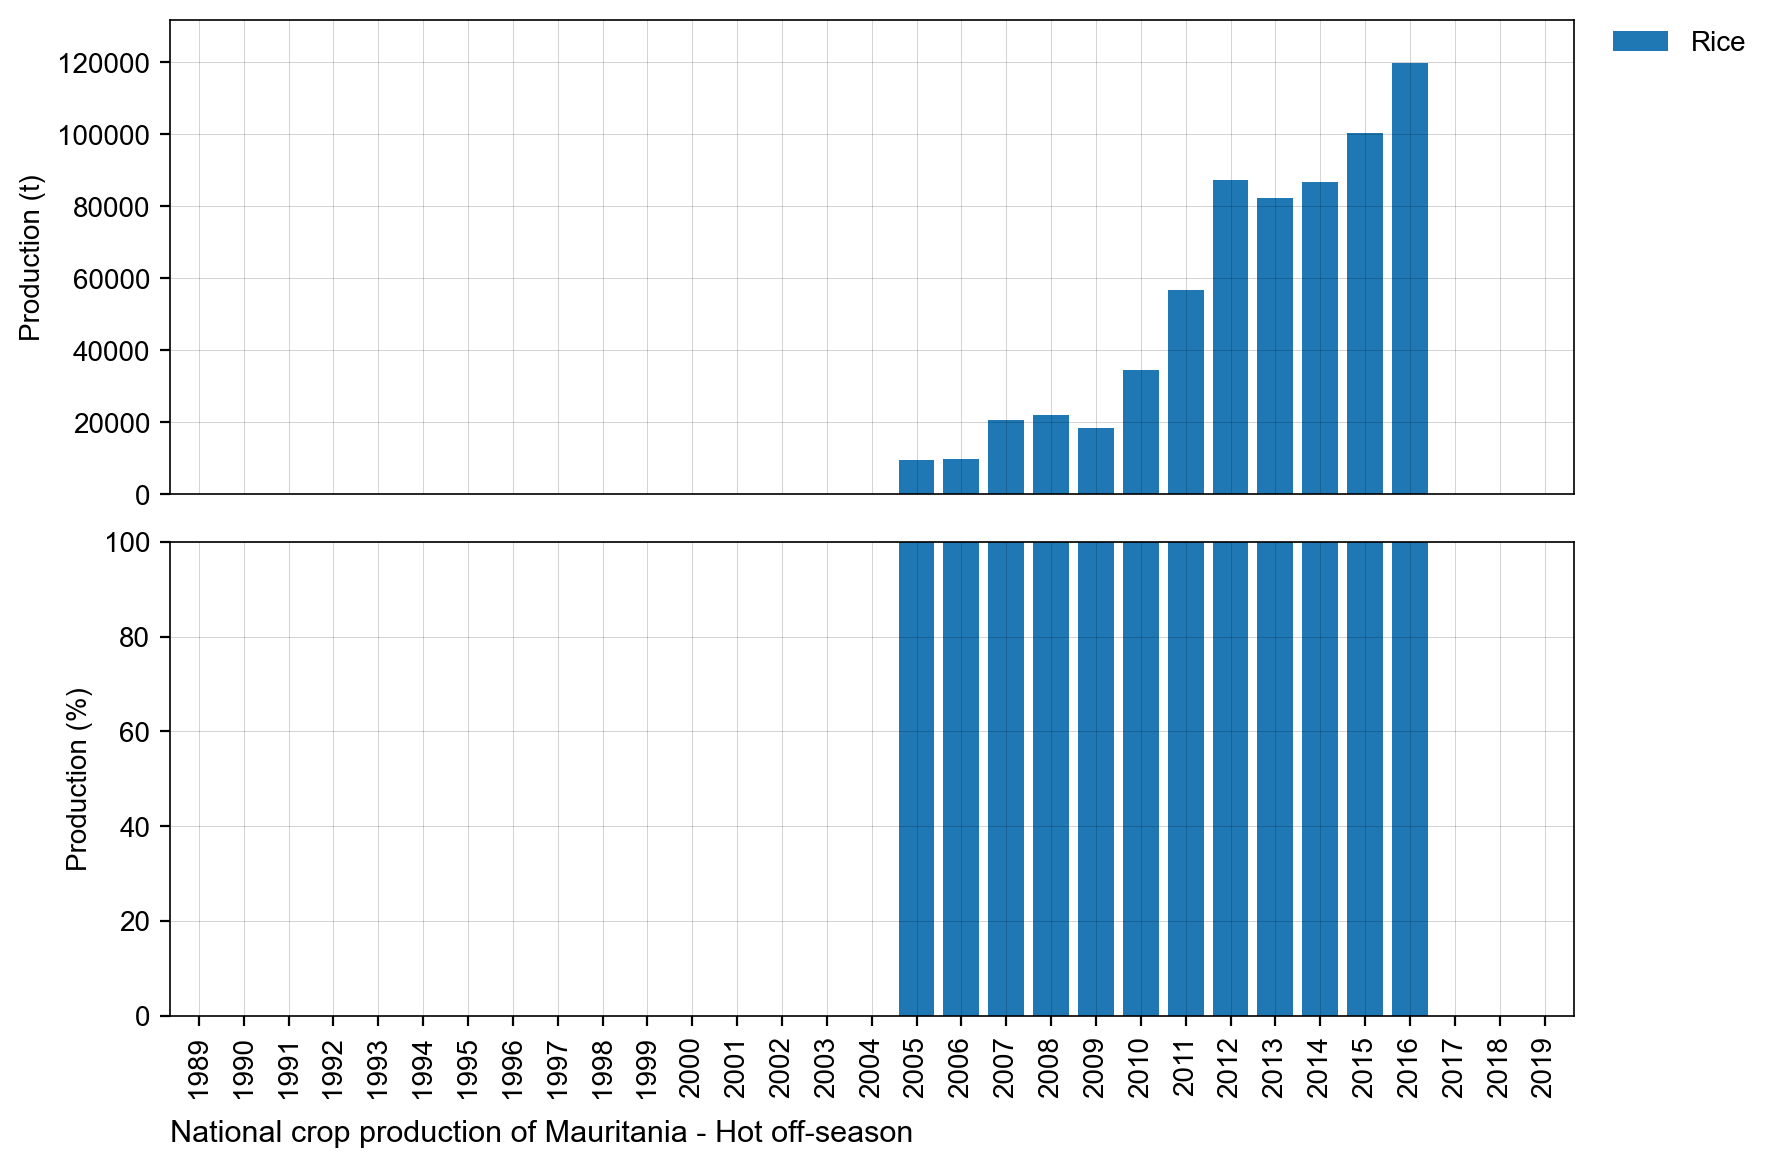

../figures/MR_bar_natgrainprod_Hot off-season.png is saved.


/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


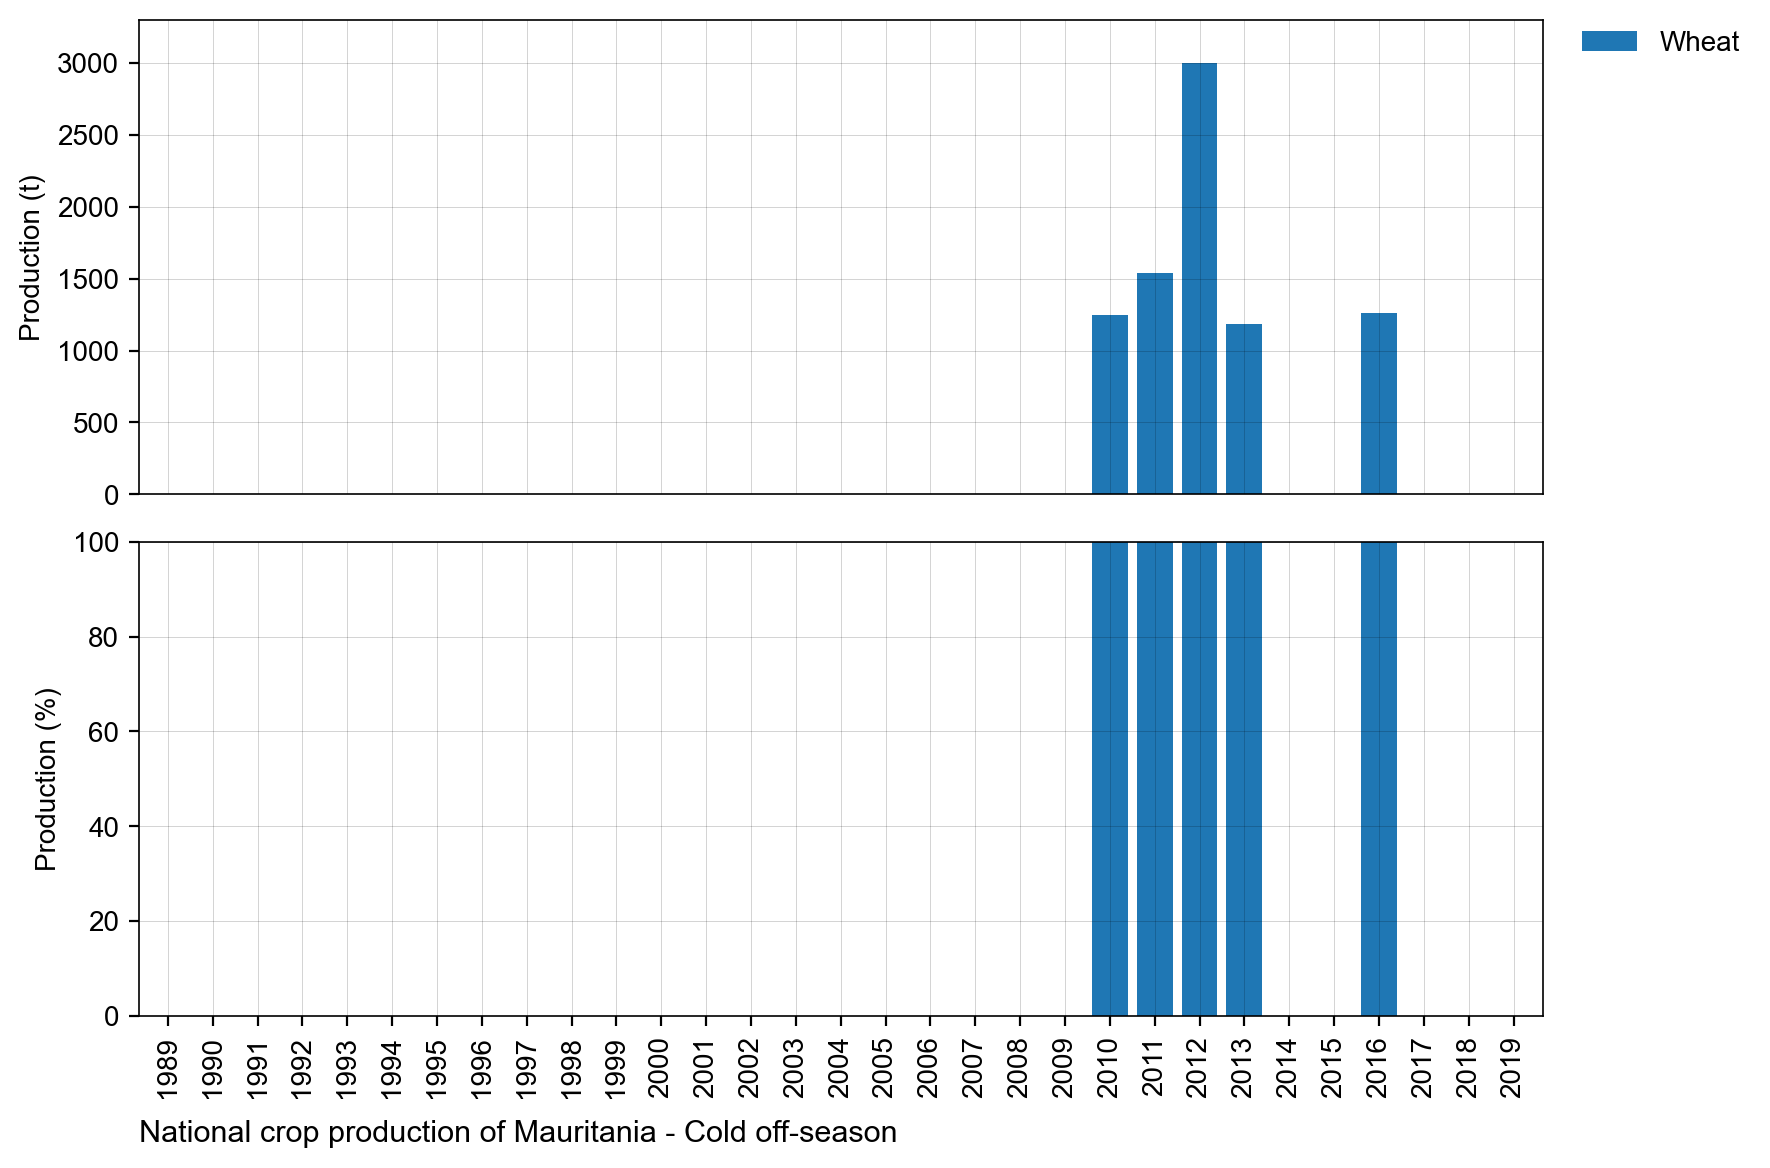

../figures/MR_bar_natgrainprod_Cold off-season.png is saved.


In [9]:
# Bar chart of national grain production
country_iso, country_name = 'MR', 'Mauritania'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Sorghum','Maize','Rice','Millet','Wheat']
for season_name in ['Annual', 'Dam retention', 'Bas-fond', 'Main', 'Walo', 'Hot off-season', 'Cold off-season']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

TypeError: pointplot() got an unexpected keyword argument 'linewidth'

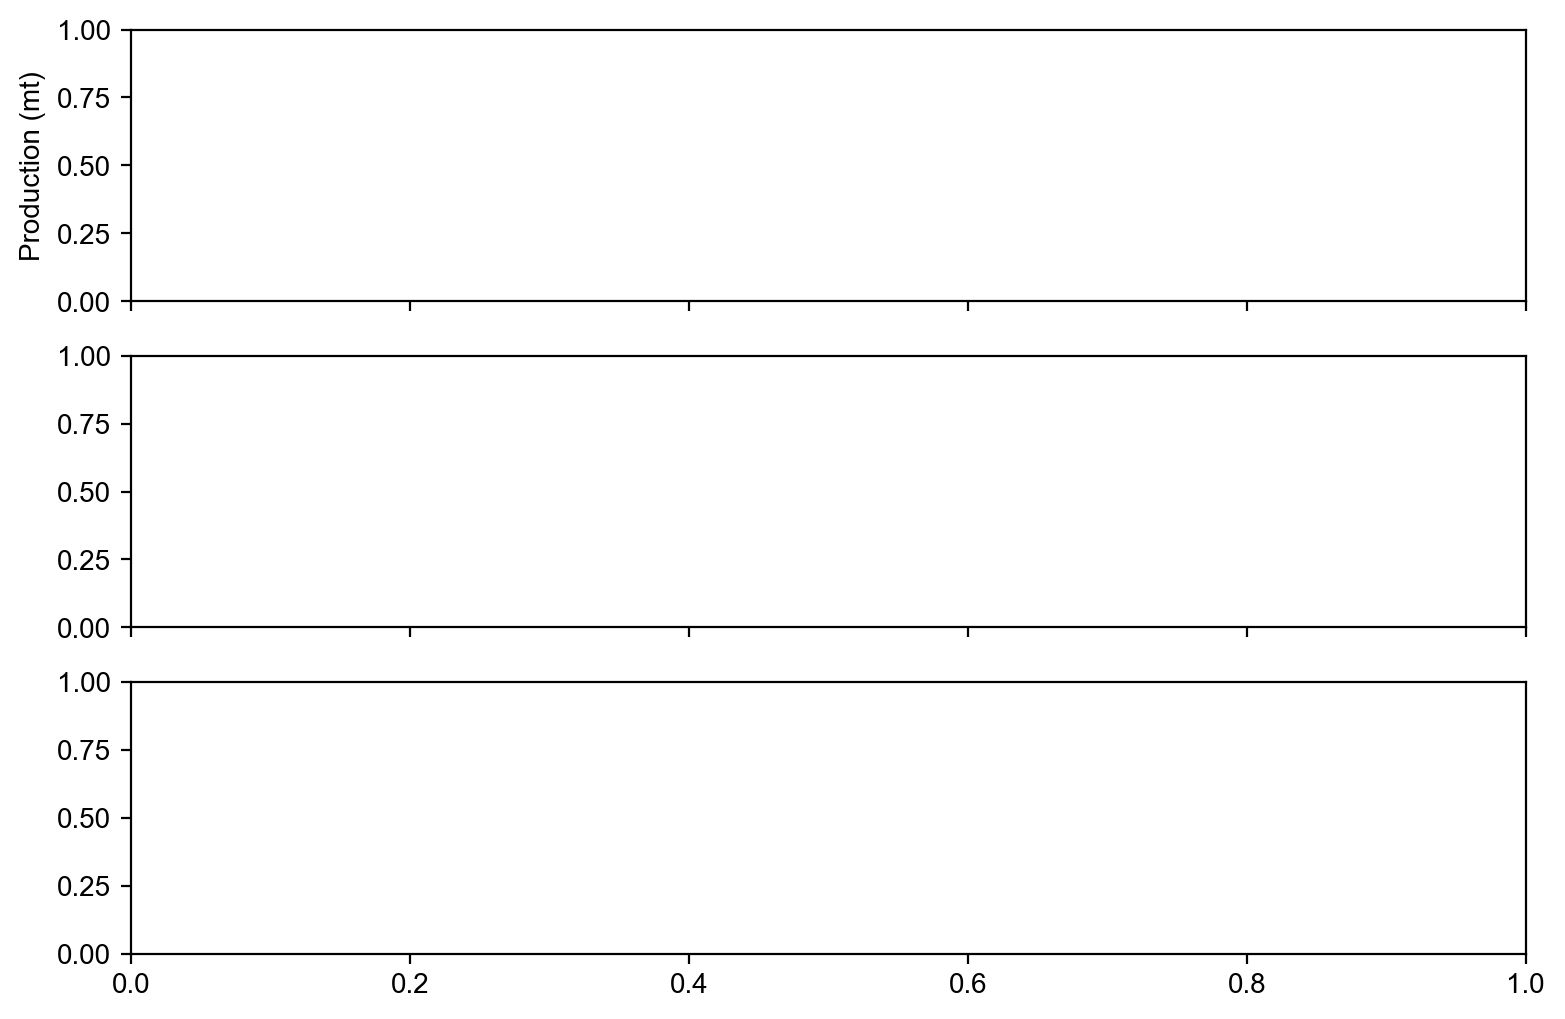

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'MR', 'Mauritania'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
product_season = [
    ['Maize','Main'],
    ['Maize','Annual'],
    ['Maize','Bas-fond'],
    ['Rice','Annual'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)